In [1]:
!nvidia-smi

Sun Mar 17 23:01:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX150           On  | 00000000:01:00.0 Off |                  N/A |
| N/A   58C    P0              N/A / ERR! |      4MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
import torch
import torch.nn as nn

torch.cuda.get_device_name(0)

'NVIDIA GeForce MX150'

In [2]:
torch.cuda.is_available()

True

In [4]:
torch.get_num_threads()

4

In [5]:
# create if not existts directory for models
!mkdir -p ./lab2-models

model_dir = './lab2-models'

1) Zwiekszenie batch size -> szbyciej sie uczy, ale mniej dokladnie
2) Zwiekszenie batch size oraz learning rate -> szybsza nauka przy takiej samej dokladnosci
3) SGD vs ADAM
4) Learning rate adjactments -> https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
5) Adding Momentum
6) 

In [6]:
# download mnist 
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

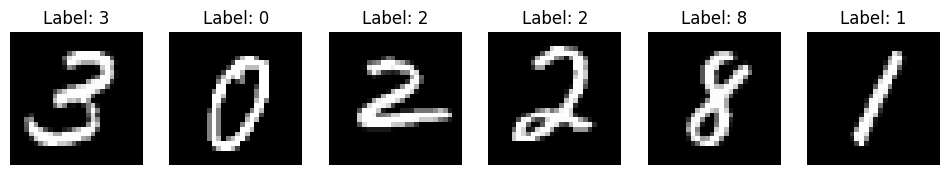

In [7]:
# sample data
import matplotlib.pyplot as plt

import numpy as np

loader = torch.utils.data.DataLoader(trainset, batch_size=124, shuffle=True)

dataiter = iter(loader)
images, labels = next(dataiter)

num_images = 6

fig, axes = plt.subplots(1, num_images, figsize=(12, 6))

for i in range(num_images):
    image = images[i].squeeze().cpu().numpy()
    label = labels[i].item()
    
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.show()

In [37]:
# define model
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)        
        # return F.log_softmax(x, dim=1)
        return x

In [69]:
# train model

import torch.optim as optim
from sklearn.metrics import precision_score, f1_score
import time

def train(net, trainloader, criterion, optimizer):
    learning_start = time.time()
    
    net.train()

    accuracies = []
    losses = []
    f1s = []

    epochs = 1
    points_to_print = 200
    print_every_n_batches = round(epochs * len(trainloader) / points_to_print)

    for epoch in range(epochs):
        running_accuracy = 0.0
        running_loss = 0.0
        running_precision = 0.0
        running_f1 = 0.0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            inputs = inputs.cuda()
            labels = labels.cuda()
    
            optimizer.zero_grad()
    
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            pred_labels = outputs.argmax(dim=1).cpu().detach().numpy()
            true_labels = labels.cpu().detach().numpy()

            running_accuracy += (outputs.argmax(dim=1) == labels).float().mean().item()
            running_loss += loss.item()
            
            running_precision += precision_score(true_labels, pred_labels, average='macro', labels=np.unique(pred_labels))
            running_f1 += f1_score(true_labels, pred_labels, average='macro', labels=np.unique(pred_labels))

            if i % print_every_n_batches == print_every_n_batches - 1:
                print('[%d, %5d] loss: %.3f, accuracy: %.3f' % (epoch + 1, i + 1, running_loss / print_every_n_batches, running_accuracy / print_every_n_batches))

                losses.append(running_loss / print_every_n_batches)
                accuracies.append(running_accuracy / print_every_n_batches)
                f1s.append(running_f1 / print_every_n_batches)

                running_accuracy = running_loss = running_precision = running_f1 = 0.0
    
    learning_end = time.time()

    return losses, accuracies, f1s, learning_end - learning_start    

In [71]:
# test model

from torchmetrics import classification as metrics

def test(net, testloader, criterion, classnum):
    testing_start = time.time()
    
    accuracy = metrics.MulticlassAccuracy(num_classes=classnum, average='macro').cuda()
    f1 = metrics.MulticlassF1Score(num_classes=classnum, average='macro').cuda()
    total_loss = 0.0

    with torch.no_grad():
        net.eval()
        
        for images, labels in testloader:

            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            accuracy.update(outputs, labels)
            f1.update(outputs, labels)
            
    
    testing_end = time.time()

    return total_loss / len(testloader), accuracy.compute().item(), f1.compute().item(), testing_end - testing_start

In [11]:
# plot training metrics

def plot(train_losses, train_accuracies, train_f1s):
    fig, ax1 = plt.subplots()
    
    metric_min = min(min(train_accuracies), min(train_f1s))

    color = 'tab:red'
    ax1.set_xlabel('batch')
    ax1.set_ylabel('loss', color=color)
    ax1.plot(train_losses, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)
    ax2.plot(train_accuracies, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim([metric_min, 1])

    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    color = 'tab:gray'
    ax3.set_ylabel('f1', color=color)
    ax3.plot(train_f1s, color=color)
    ax3.tick_params(axis='y', labelcolor=color)
    ax3.set_ylim([metric_min, 1])
    
    ax1.set_xlim([0, 200])

    fig.tight_layout()
    plt.title('Train accuracy, loss, precision and f1')
    plt.show()

In [72]:
# model wrapper

import pickle


class Model:
    def __init__(self, name, net, trainloader, criterion, optimizer):
        self.name = name
        self.net = net
        self.trainloader = trainloader
        self.criterion = criterion
        self.optimizer = optimizer

        self.train_losses = []
        self.train_accuracies = []
        self.train_f1s = []
        self.train_time = 0

        self.test_loss = 0
        self.test_accuracy = 0
        self.test_f1 = 0
        self.test_time = 0

    def train_and_test(self):
        self.train()
        self.test()

    # train model
    def train(self):
        print(f'Training {self.name}...')
        self.train_losses, self.train_accuracies, self.train_f1s, self.train_time = train(
            self.net, self.trainloader, self.criterion, self.optimizer)

        self.save()

    # test model
    def test(self):
        print(f'Testing {self.name}...')
        self.test_loss, self.test_accuracy, self.test_f1, self.test_time = test(
            self.net, testloader, self.criterion, len(testset.classes))

        return self.test_accuracy, self.test_f1, self.test_time

    # plot model
    def plot(self):
        plot(self.train_losses, self.train_accuracies, self.train_f1s)

    def show_table(self):
        print(f'Name: {self.name}')
        print(f'Train time: {self.train_time:.2f} s')
        print(f'Test time: {self.test_time:.2f} s')
        print(f'Test accuracy: {self.test_accuracy*100:.3f}%')
        print(f'Test f1: {self.test_f1:.3f}')

    # save self to file
    def save(self):
        print(f'Saving {self.name}...')
        torch.save(self.net.state_dict(), f'{model_dir}/{self.name}.pth')

        with open(f'{model_dir}/{self.name}.pkl', 'wb') as f:
            pickle.dump(self, f)

    # load self from file
    @classmethod
    def load(cls, name):
        with open(f'{model_dir}/{name}.pkl', 'rb') as f:
            return pickle.load(f)

In [45]:
net = Net().cuda()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=124, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

baseline_model = Model('baseline-model', net, trainloader, criterion, optimizer)
baseline_model.train_and_test()

baseline_model.show_table()

Training baseline-model...
[1,    24] loss: 2.187, accuracy: 0.358
[1,    48] loss: 1.186, accuracy: 0.731
[1,    72] loss: 0.458, accuracy: 0.859
[1,    96] loss: 0.331, accuracy: 0.896
[1,   120] loss: 0.280, accuracy: 0.912
[1,   144] loss: 0.225, accuracy: 0.934
[1,   168] loss: 0.210, accuracy: 0.940
[1,   192] loss: 0.215, accuracy: 0.935
[1,   216] loss: 0.180, accuracy: 0.947
[1,   240] loss: 0.190, accuracy: 0.944
[1,   264] loss: 0.147, accuracy: 0.954
[1,   288] loss: 0.150, accuracy: 0.954
[1,   312] loss: 0.170, accuracy: 0.947
[1,   336] loss: 0.147, accuracy: 0.954
[1,   360] loss: 0.127, accuracy: 0.961
[1,   384] loss: 0.119, accuracy: 0.962
[1,   408] loss: 0.117, accuracy: 0.965
[1,   432] loss: 0.122, accuracy: 0.962
[1,   456] loss: 0.114, accuracy: 0.963
[1,   480] loss: 0.117, accuracy: 0.966
[2,    24] loss: 0.095, accuracy: 0.973
[2,    48] loss: 0.087, accuracy: 0.973
[2,    72] loss: 0.096, accuracy: 0.970
[2,    96] loss: 0.075, accuracy: 0.974
[2,   120] lo

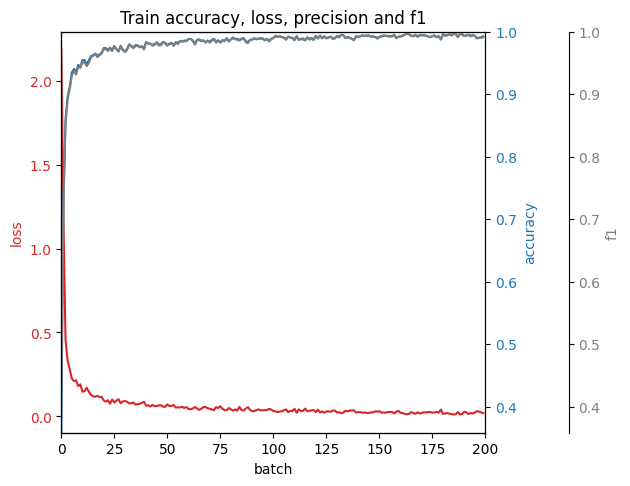

In [46]:
baseline_model.plot()

In [15]:
# Hipothesis 1: increase batch size results in faster learning and worse accuracy

net = Net().cuda()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

batch_size_model = Model('hip-1-model', net, trainloader, criterion, optimizer)
batch_size_model.train_and_test()

batch_size_model.show_table()

Training hip-1-model...
[1,     3] loss: 2.300, accuracy: 0.100
[1,     6] loss: 2.278, accuracy: 0.163
[1,     9] loss: 2.250, accuracy: 0.285
[1,    12] loss: 2.192, accuracy: 0.362
[1,    15] loss: 2.098, accuracy: 0.450
[1,    18] loss: 1.975, accuracy: 0.493
[1,    21] loss: 1.818, accuracy: 0.528
[1,    24] loss: 1.608, accuracy: 0.594
[1,    27] loss: 1.384, accuracy: 0.675
[1,    30] loss: 1.185, accuracy: 0.702
[1,    33] loss: 1.016, accuracy: 0.725
[1,    36] loss: 0.843, accuracy: 0.761
[1,    39] loss: 0.756, accuracy: 0.768
[1,    42] loss: 0.682, accuracy: 0.789
[1,    45] loss: 0.579, accuracy: 0.825
[1,    48] loss: 0.548, accuracy: 0.839
[1,    51] loss: 0.487, accuracy: 0.859
[1,    54] loss: 0.463, accuracy: 0.860
[1,    57] loss: 0.445, accuracy: 0.862
[2,     3] loss: 0.386, accuracy: 0.889
[2,     6] loss: 0.358, accuracy: 0.887
[2,     9] loss: 0.364, accuracy: 0.891
[2,    12] loss: 0.322, accuracy: 0.898
[2,    15] loss: 0.311, accuracy: 0.909
[2,    18] loss:

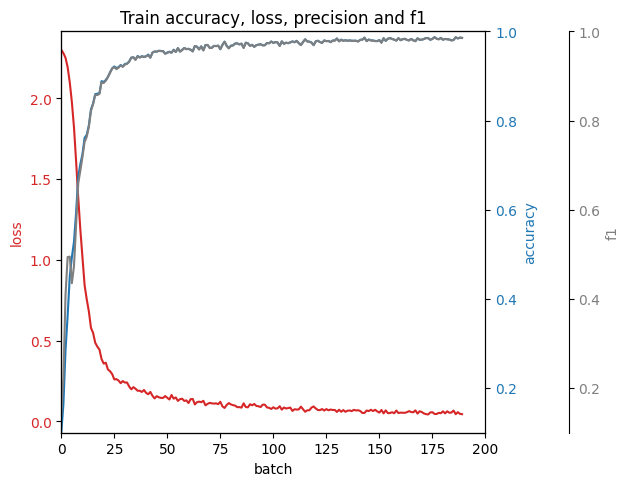

In [16]:
batch_size_model.plot()

In [17]:
# Hopothesis 2: increase learning rate with increased batch size results in faster learning and better accuracy

net = Net().cuda()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

batch_size_learning_rate_model = Model('hip-2-model', net, trainloader, criterion, optimizer)
batch_size_learning_rate_model.train_and_test()

batch_size_learning_rate_model.show_table()

Training hip-2-model...
[1,     3] loss: 2.251, accuracy: 0.136
[1,     6] loss: 1.683, accuracy: 0.496
[1,     9] loss: 1.080, accuracy: 0.688
[1,    12] loss: 0.680, accuracy: 0.790
[1,    15] loss: 0.518, accuracy: 0.840
[1,    18] loss: 0.424, accuracy: 0.874
[1,    21] loss: 0.306, accuracy: 0.911
[1,    24] loss: 0.296, accuracy: 0.914
[1,    27] loss: 0.217, accuracy: 0.934
[1,    30] loss: 0.202, accuracy: 0.938
[1,    33] loss: 0.179, accuracy: 0.943
[1,    36] loss: 0.165, accuracy: 0.946
[1,    39] loss: 0.160, accuracy: 0.956
[1,    42] loss: 0.158, accuracy: 0.952
[1,    45] loss: 0.138, accuracy: 0.957
[1,    48] loss: 0.140, accuracy: 0.956
[1,    51] loss: 0.106, accuracy: 0.966
[1,    54] loss: 0.106, accuracy: 0.967
[1,    57] loss: 0.101, accuracy: 0.970
[2,     3] loss: 0.084, accuracy: 0.977
[2,     6] loss: 0.078, accuracy: 0.975
[2,     9] loss: 0.070, accuracy: 0.975
[2,    12] loss: 0.069, accuracy: 0.977
[2,    15] loss: 0.076, accuracy: 0.977
[2,    18] loss:

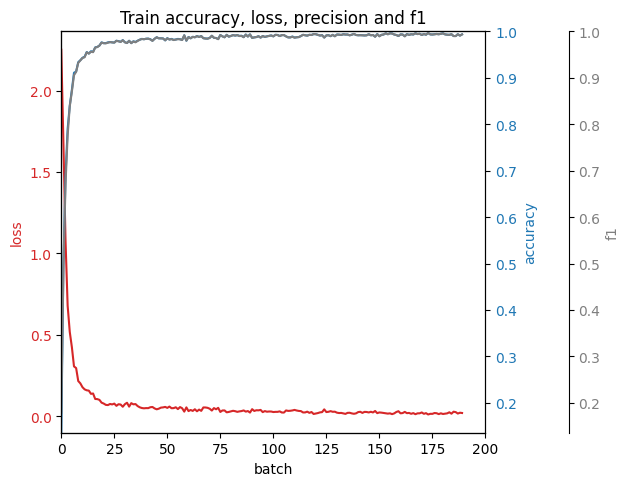

In [18]:
batch_size_learning_rate_model.plot()

In [19]:
# Hipothesis 3: Adam is better than SGD

net = Net().cuda()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=124, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

sgd_model = Model('hip-3-model', net, trainloader, criterion, optimizer)
sgd_model.train_and_test()

sgd_model.show_table()

Training hip-3-model...
[1,    24] loss: 2.301, accuracy: 0.109
[1,    48] loss: 2.305, accuracy: 0.098
[1,    72] loss: 2.304, accuracy: 0.104
[1,    96] loss: 2.302, accuracy: 0.114
[1,   120] loss: 2.303, accuracy: 0.108
[1,   144] loss: 2.304, accuracy: 0.106
[1,   168] loss: 2.304, accuracy: 0.109
[1,   192] loss: 2.304, accuracy: 0.117
[1,   216] loss: 2.301, accuracy: 0.108
[1,   240] loss: 2.303, accuracy: 0.112
[1,   264] loss: 2.300, accuracy: 0.121
[1,   288] loss: 2.305, accuracy: 0.113
[1,   312] loss: 2.304, accuracy: 0.115
[1,   336] loss: 2.301, accuracy: 0.125
[1,   360] loss: 2.302, accuracy: 0.115
[1,   384] loss: 2.298, accuracy: 0.137
[1,   408] loss: 2.300, accuracy: 0.129
[1,   432] loss: 2.302, accuracy: 0.131
[1,   456] loss: 2.301, accuracy: 0.130
[1,   480] loss: 2.301, accuracy: 0.124
[2,    24] loss: 2.300, accuracy: 0.149
[2,    48] loss: 2.299, accuracy: 0.144
[2,    72] loss: 2.302, accuracy: 0.144
[2,    96] loss: 2.301, accuracy: 0.143
[2,   120] loss:

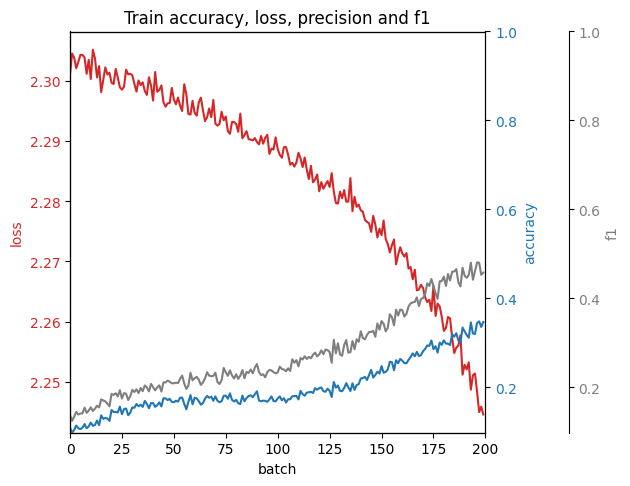

In [20]:
sgd_model.plot()

In [21]:
# Hipothesis 4: SGD with momentum is better than Adam

net = Net().cuda()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=124, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

sgd_momentum_model = Model('hip-4-model', net, trainloader, criterion, optimizer)
sgd_momentum_model.train_and_test()

sgd_momentum_model.show_table()

Training hip-4-model...
[1,    24] loss: 2.308, accuracy: 0.096
[1,    48] loss: 2.304, accuracy: 0.118
[1,    72] loss: 2.302, accuracy: 0.136
[1,    96] loss: 2.298, accuracy: 0.158
[1,   120] loss: 2.296, accuracy: 0.182
[1,   144] loss: 2.295, accuracy: 0.219
[1,   168] loss: 2.294, accuracy: 0.223
[1,   192] loss: 2.292, accuracy: 0.196
[1,   216] loss: 2.291, accuracy: 0.159
[1,   240] loss: 2.287, accuracy: 0.149
[1,   264] loss: 2.286, accuracy: 0.163
[1,   288] loss: 2.283, accuracy: 0.168
[1,   312] loss: 2.279, accuracy: 0.193
[1,   336] loss: 2.273, accuracy: 0.205
[1,   360] loss: 2.269, accuracy: 0.247
[1,   384] loss: 2.264, accuracy: 0.277
[1,   408] loss: 2.257, accuracy: 0.284
[1,   432] loss: 2.245, accuracy: 0.289
[1,   456] loss: 2.238, accuracy: 0.295
[1,   480] loss: 2.223, accuracy: 0.317
[2,    24] loss: 2.201, accuracy: 0.356
[2,    48] loss: 2.176, accuracy: 0.391
[2,    72] loss: 2.136, accuracy: 0.444
[2,    96] loss: 2.088, accuracy: 0.448
[2,   120] loss:

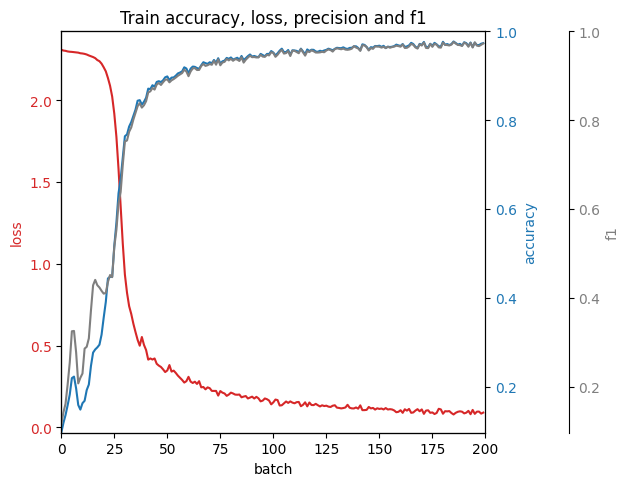

In [22]:
sgd_momentum_model.plot()

In [23]:
# Hipothesis 5: SGD with momentum and decay is better than SGD with momentum

net = Net().cuda()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=124, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

sgd_momentum_decay_model = Model('hip-5-model', net, trainloader, criterion, optimizer)
sgd_momentum_decay_model.train_and_test()

sgd_momentum_decay_model.show_table()

Training hip-5-model...
[1,    24] loss: 2.300, accuracy: 0.118
[1,    48] loss: 2.299, accuracy: 0.132
[1,    72] loss: 2.295, accuracy: 0.138
[1,    96] loss: 2.294, accuracy: 0.133
[1,   120] loss: 2.290, accuracy: 0.140
[1,   144] loss: 2.287, accuracy: 0.148
[1,   168] loss: 2.285, accuracy: 0.156
[1,   192] loss: 2.282, accuracy: 0.179
[1,   216] loss: 2.278, accuracy: 0.197
[1,   240] loss: 2.274, accuracy: 0.228
[1,   264] loss: 2.269, accuracy: 0.283
[1,   288] loss: 2.263, accuracy: 0.332
[1,   312] loss: 2.255, accuracy: 0.390
[1,   336] loss: 2.247, accuracy: 0.381
[1,   360] loss: 2.235, accuracy: 0.410
[1,   384] loss: 2.224, accuracy: 0.447
[1,   408] loss: 2.202, accuracy: 0.469
[1,   432] loss: 2.179, accuracy: 0.462
[1,   456] loss: 2.148, accuracy: 0.464
[1,   480] loss: 2.110, accuracy: 0.468
[2,    24] loss: 2.024, accuracy: 0.504
[2,    48] loss: 1.931, accuracy: 0.513
[2,    72] loss: 1.799, accuracy: 0.566
[2,    96] loss: 1.619, accuracy: 0.618
[2,   120] loss:

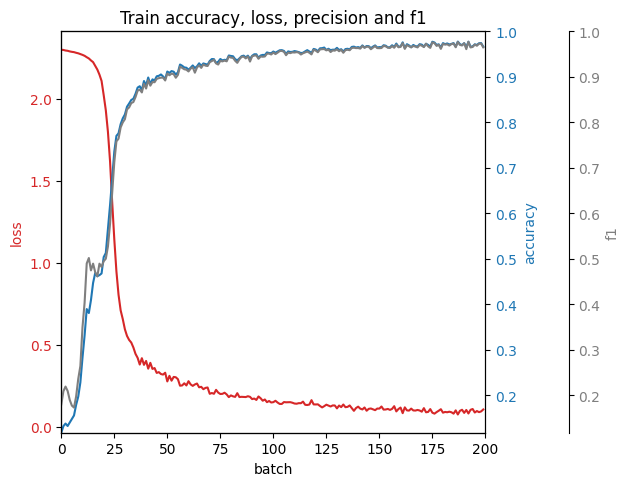

In [24]:
sgd_momentum_decay_model.plot()

In [38]:
# Hipothesis 6: different loss function

net = Net().cuda()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=124, shuffle=True)
criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

nll_model = Model('hip-6-model', net, trainloader, criterion, optimizer)
nll_model.train_and_test()

nll_model.show_table()

Training hip-6-model...
[1,    24] loss: 2.175, accuracy: 0.301
[1,    48] loss: 1.140, accuracy: 0.692
[1,    72] loss: 0.515, accuracy: 0.840
[1,    96] loss: 0.375, accuracy: 0.889
[1,   120] loss: 0.323, accuracy: 0.896
[1,   144] loss: 0.294, accuracy: 0.911
[1,   168] loss: 0.268, accuracy: 0.917
[1,   192] loss: 0.222, accuracy: 0.928
[1,   216] loss: 0.190, accuracy: 0.944
[1,   240] loss: 0.169, accuracy: 0.948
[1,   264] loss: 0.199, accuracy: 0.941
[1,   288] loss: 0.166, accuracy: 0.950
[1,   312] loss: 0.170, accuracy: 0.948
[1,   336] loss: 0.137, accuracy: 0.955
[1,   360] loss: 0.136, accuracy: 0.959
[1,   384] loss: 0.139, accuracy: 0.956
[1,   408] loss: 0.115, accuracy: 0.964
[1,   432] loss: 0.118, accuracy: 0.962
[1,   456] loss: 0.128, accuracy: 0.962
[1,   480] loss: 0.124, accuracy: 0.962
[2,    24] loss: 0.118, accuracy: 0.961
[2,    48] loss: 0.082, accuracy: 0.975
[2,    72] loss: 0.087, accuracy: 0.973
[2,    96] loss: 0.099, accuracy: 0.971
[2,   120] loss:

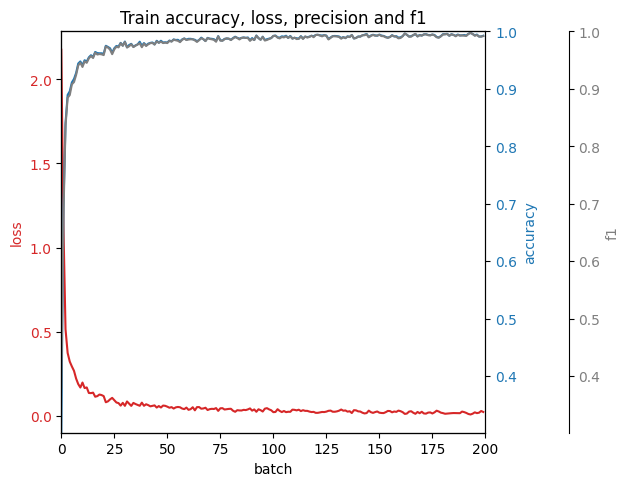

In [44]:
nll_model.plot()

In [48]:
# Hipothesis 7: rms props

net = Net().cuda()
trainloader = torch.utils.data.DataLoader(trainset, batch_size=124, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.001)

rms_model = Model('hip-7-model', net, trainloader, criterion, optimizer)
rms_model.train_and_test()

rms_model.show_table()

Training hip-7-model...
[1,    24] loss: 1.704, accuracy: 0.425
[1,    48] loss: 0.553, accuracy: 0.835
[1,    72] loss: 0.336, accuracy: 0.896
[1,    96] loss: 0.273, accuracy: 0.917
[1,   120] loss: 0.209, accuracy: 0.938
[1,   144] loss: 0.163, accuracy: 0.950
[1,   168] loss: 0.146, accuracy: 0.956
[1,   192] loss: 0.168, accuracy: 0.947
[1,   216] loss: 0.125, accuracy: 0.962
[1,   240] loss: 0.144, accuracy: 0.955
[1,   264] loss: 0.111, accuracy: 0.964
[1,   288] loss: 0.118, accuracy: 0.964
[1,   312] loss: 0.102, accuracy: 0.966
[1,   336] loss: 0.114, accuracy: 0.964
[1,   360] loss: 0.105, accuracy: 0.966
[1,   384] loss: 0.099, accuracy: 0.971
[1,   408] loss: 0.094, accuracy: 0.973
[1,   432] loss: 0.106, accuracy: 0.968
[1,   456] loss: 0.090, accuracy: 0.973
[1,   480] loss: 0.081, accuracy: 0.974
[2,    24] loss: 0.078, accuracy: 0.975
[2,    48] loss: 0.070, accuracy: 0.978
[2,    72] loss: 0.093, accuracy: 0.971
[2,    96] loss: 0.078, accuracy: 0.976
[2,   120] loss:

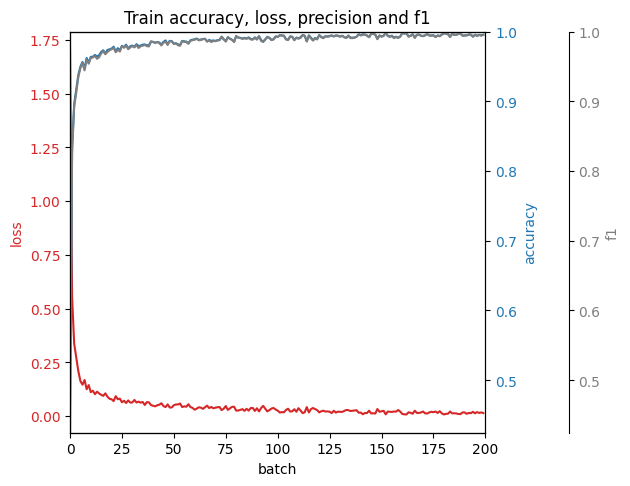

In [49]:
rms_model.plot()

In [74]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'loss_function': ['nnloss', 'binary_crossentropy'],
    'batch_size': [64, 128, 1024],
    'learning_rate': [0.001, 0.01, 0.1],
    'momentum': [0, 0.9],
}

def getLossFunction(loss_function):
    return nn.NLLLoss() if loss_function == 'nnloss' else nn.CrossEntropyLoss()

def getUniqueName(params):
    return f'hyper-{params["optimizer"]}-{params["loss_function"]}-{params["batch_size"]}-{params["learning_rate"]}-{params["momentum"]}'


print(f'Models to train: {len(ParameterGrid(param_grid))}')

results = []
i = 0
for params in ParameterGrid(param_grid):
    print(f'Training model {i+1}...')
    if params['optimizer'] != 'sgd' and params['momentum'] == 0.9:
        continue
    
    if params['optimizer'] == 'sgd' :
        net = Net().cuda()
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=params['batch_size'], shuffle=True)
        criterion =  getLossFunction(params['loss_function'])
        optimizer = optim.SGD(net.parameters(), lr=params['learning_rate'], momentum=params['momentum'])
    else:
        net = Net().cuda()
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=params['batch_size'], shuffle=True)
        criterion =  getLossFunction(params['loss_function'])
        optimizer = optim.Adam(net.parameters(), lr=params['learning_rate'])
    
    model = Model(getUniqueName(params), net, trainloader, criterion, optimizer)    
    model.train_and_test()
    
    results.append({
        'params': params,
        'name': model.name,
        'train_time': model.train_time,
        'test_time': model.test_time,
        'test_loss': model.test_loss,
        'test_accuracy': model.test_accuracy,
        'test_f1': model.test_f1
    })
    
    i += 1
    
print('Training finished')
print(results)

Models to train: 108
Training model 1...
Training hyper-adam-nnloss-64-0.001-0...
[1,     5] loss: 2.294, accuracy: 0.138
[1,    10] loss: 2.274, accuracy: 0.175
[1,    15] loss: 2.227, accuracy: 0.359
[1,    20] loss: 2.153, accuracy: 0.384
[1,    25] loss: 1.997, accuracy: 0.503
[1,    30] loss: 1.806, accuracy: 0.503
[1,    35] loss: 1.476, accuracy: 0.634
[1,    40] loss: 1.216, accuracy: 0.644
[1,    45] loss: 0.972, accuracy: 0.691
[1,    50] loss: 0.892, accuracy: 0.703
[1,    55] loss: 0.688, accuracy: 0.791
[1,    60] loss: 0.747, accuracy: 0.787
[1,    65] loss: 0.745, accuracy: 0.772
[1,    70] loss: 0.598, accuracy: 0.809
[1,    75] loss: 0.662, accuracy: 0.822
[1,    80] loss: 0.553, accuracy: 0.828
[1,    85] loss: 0.662, accuracy: 0.822
[1,    90] loss: 0.461, accuracy: 0.834
[1,    95] loss: 0.517, accuracy: 0.841
[1,   100] loss: 0.471, accuracy: 0.866
[1,   105] loss: 0.426, accuracy: 0.853
[1,   110] loss: 0.427, accuracy: 0.881
[1,   115] loss: 0.370, accuracy: 0.88

ZeroDivisionError: integer division or modulo by zero

In [70]:
len(ParameterGrid(param_grid)) * (10) / 3060

0.35294117647058826